In [1]:
import os
import numpy as np
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
import copy 
from ucimlrepo import fetch_ucirepo 

import torch
import torch.nn as nn
import torch.optim as optim
from hyperopt import fmin, tpe, hp, Trials
from hyperopt.pyll.base import scope

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, matthews_corrcoef
from sklearn.model_selection import train_test_split


from ltn_imp.automation.knowledge_base import KnowledgeBase

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Prepare Dataset

In [3]:
breast_cancer_wisconsin_original = fetch_ucirepo(id=15) 
X = breast_cancer_wisconsin_original.data.features 
y = breast_cancer_wisconsin_original.data.targets 
data = pd.DataFrame(X, columns=breast_cancer_wisconsin_original.data.feature_names)
data = data * 10

data["Label"] = y
data["Label"] = data["Label"].map({4: 1, 2: 0})
data.head()

,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses,Label
0,50,10,10,10,20,10.0,30,10,10,0
1,50,40,40,50,70,100.0,30,20,10,0
2,30,10,10,10,20,20.0,30,10,10,0
3,60,80,80,10,30,40.0,30,70,10,0
4,40,10,10,30,20,10.0,30,10,10,0


In [4]:
data.columns

Index(['Clump_thickness', 'Uniformity_of_cell_size',
       'Uniformity_of_cell_shape', 'Marginal_adhesion',
       'Single_epithelial_cell_size', 'Bare_nuclei', 'Bland_chromatin',
       'Normal_nucleoli', 'Mitoses', 'Label'],
      dtype='object')

In [5]:
print(data.isna().sum())
data = data.dropna()

Clump_thickness                 0
Uniformity_of_cell_size         0
Uniformity_of_cell_shape        0
Marginal_adhesion               0
Single_epithelial_cell_size     0
Bare_nuclei                    16
Bland_chromatin                 0
Normal_nucleoli                 0
Mitoses                         0
Label                           0
dtype: int64


In [6]:
def prepare_datasets(data, random_seed=42):    
    X = data.drop("Label", axis=1)  # Features
    y = data["Label"]  # Labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed, stratify=y)    
    train_data = pd.concat([X_train, y_train], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)
    train_data.to_csv("datasets/train.csv", index=False)
    test_data.to_csv("datasets/test.csv", index=False)
    return train_data, test_data

In [7]:
prepare_datasets(data)
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")
data = pd.concat([train, test])
print(train.shape)
print(test.shape)

(478, 10)
(205, 10)


In [8]:
data.value_counts("Label")

Label
0    444
1    239
Name: count, dtype: int64

# Best Hyper-Parameters

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def find_best_models(X,y):
    param_grid = {

        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]
            }
        },

        'DT': {
            'model': DecisionTreeClassifier(),
            'params': {
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'criterion': ['gini', 'entropy']
            }
        },

        'RF': {
            'model': RandomForestClassifier(),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5],
                'criterion': ['gini', 'entropy']
            }
        },
        
        'LR': {
            'model': LogisticRegression(max_iter=1000),
            'params': {
                'C': [0.1, 1, 10],
                'solver': ['lbfgs', 'liblinear']
            }
        }
    }

    best_models = {}
    for name, model_info in param_grid.items():
        grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=5, n_jobs=-1)
        grid_search.fit(X, y)
        best_models[name] = grid_search.best_estimator_

    models = []
    for name, model in best_models.items():
        if name == 'KNN':
            models.append(KNeighborsClassifier(**model.get_params()))
        elif name == 'DT':
            models.append(DecisionTreeClassifier(**model.get_params()))
        elif name == 'RF':
            models.append(RandomForestClassifier(**model.get_params()))
        elif name == 'LR':
            models.append(LogisticRegression(**model.get_params()))

    return models

In [10]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, dropout_prob=0.5):
        super(MLP, self).__init__()
        layers = []
        in_size = input_size
        
        # Build layers with dropout
        for out_size in hidden_layers:
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.LeakyReLU())  # LeakyReLU activation
            layers.append(nn.Dropout(p=dropout_prob))  # Dropout layer
            in_size = out_size
        
        # Output layer
        layers.append(nn.Linear(in_size, output_size))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [11]:
kb = KnowledgeBase("config.yaml")

def objective(params):
    learning_rate = params['learning_rate']
    weight_decay = params['weight_decay']
    hidden_layer_sizes = params['hidden_layer_sizes']
    num_epochs = params['num_epochs']
    dropout_prob = params['dropout_prob'] 

    model = MLP(input_size=9, output_size=1, hidden_layers=hidden_layer_sizes, dropout_prob=dropout_prob)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model.train()
    for epoch in range(num_epochs): 
        for batch_X, batch_y in kb.loaders[0]:  
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_X, batch_y in kb.test_loaders[0]:  
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
    
    return total_loss

# Define the hyperparameter search space
space = {
    'learning_rate': hp.loguniform('learning_rate', -6, -1),  # 1e-5 to 1
    'weight_decay': hp.loguniform('weight_decay', -5, -1),   # 1e-6 to 1e-2

    'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [
        [512, 256, 128, 64, 32],  # Architecture with 5 layers
        [256, 128, 64, 32],       # Architecture with 4 layers
        [512, 256, 128],          # Architecture with 3 layers
        [256, 128],               # Architecture with 2 layers
        [512],                    # Architecture with 1 layer
    ]),

    'num_epochs': scope.int(hp.quniform('num_epochs', 5, 50, 1)),  # Epochs range from 5 to 200
    'dropout_prob': hp.uniform('dropout_prob', 0.1, 0.5)  # Dropout probability between 0.1 and 0.5
}

trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,  # Use the TPE algorithm
    max_evals=1,  
    trials=trials
)

print("Best hyperparameters:", best)

Using device: cpu
100%|██████████| 1/1 [00:03<00:00,  3.07s/trial, best loss: 0.5463007092475891]
Best hyperparameters: {'dropout_prob': np.float64(0.19497173581503247), 'hidden_layer_sizes': np.int64(3), 'learning_rate': np.float64(0.10621130558425448), 'num_epochs': np.float64(17.0), 'weight_decay': np.float64(0.03270094762285982)}


# Train and Evaluate Models

In [12]:
lr = 0.001832278642898956
weight_decay = 0.15047216160202792
epochs = 20

In [13]:
models = find_best_models(train.drop("Label", axis=1), train["Label"])
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=1000, random_state=42)
models.append(mlp)

In [14]:
models.append(kb.predicates["Cancer"])

In [15]:
model_names = [type(model).__name__ for model in models]
model_names

['KNeighborsClassifier',
 'DecisionTreeClassifier',
 'RandomForestClassifier',
 'LogisticRegression',
 'MLPClassifier',
 'LogicTensorNetwork']

In [16]:
columns = train.columns[:-1]

In [17]:
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "Balanced Accuracy", "MCC"]

## This section includes all methods needed to train and evalute all models

In [18]:
device = torch.device("cpu")

def predict(model, x):
    try:
        model.eval()  # Ensure the model is in evaluation mode
    except:
        ""

    with torch.no_grad():  # No need to track gradients
        # Ensure x is a tensor and has the right dtype
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
        elif x.dtype != torch.float32:
            x = x.float()

        try:
            probs = model(x)
        except Exception as e:
            x = x.to(torch.device("cpu"))
            probs = torch.tensor(model.predict(x))

        # Apply binary classification threshold at 0.5
        preds = (probs > 0.5).float()
    return preds

def compute_metrics(model, data_loader):
    all_true_labels = []
    all_predicted_labels = []
    
    with torch.no_grad():  # Disable gradient computation
        for data, labels in data_loader:
            # Ensure data and labels are the correct dtype
            if not isinstance(data, torch.Tensor):
                data = torch.tensor(data, dtype=torch.float32)
            elif data.dtype != torch.float32:
                data = data.float()
            
            if not isinstance(labels, torch.Tensor):
                labels = torch.tensor(labels, dtype=torch.float32)
            elif labels.dtype != torch.float32:
                labels = labels.float()
            
            # Get predictions
            preds = predict(model, data)

            # Squeeze predictions and labels to remove dimensions of size 1
            predicted_labels = preds.squeeze()
            true_labels = labels.squeeze()

            # Ensure the shapes match before comparison
            if predicted_labels.shape != true_labels.shape:
                true_labels = true_labels.view_as(predicted_labels)
            
            # Collect all predictions and true labels for MCC
            all_true_labels.extend(true_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    true_labels = np.array(all_true_labels)
    predicted_labels = np.array(all_predicted_labels)
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)  # zero_division=0 handles the division by zero case
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    mcc = matthews_corrcoef(true_labels, predicted_labels)

    try:
        model.train()
    except:
        ""

    return accuracy, precision, recall, f1, balanced_accuracy, mcc

# Rule 1: Malignant if Bare_nuclei > 55
def rule_1(data_df):
    condition = (data_df['Bare_nuclei'] > 55)
    outcome = pd.Series(np.nan, index=data_df.index)
    outcome[condition] = 1  # Malignant
    return outcome

# Rule 2: Malignant if Clump_thickness > 65
def rule_2(data_df):
    condition = (data_df['Clump_thickness'] > 65)
    outcome = pd.Series(np.nan, index=data_df.index)
    outcome[condition] = 1  # Malignant
    return outcome

# Rule 3: Benign if Bare_nuclei <= 55 and Clump_thickness <= 65
def rule_3(data_df):
    condition = (data_df['Bare_nuclei'] <= 55) & (data_df['Clump_thickness'] <= 65)
    outcome = pd.Series(np.nan, index=data_df.index)
    outcome[condition] = 0  # Benign
    return outcome

# Rule 4: Benign if Bare_nuclei <= 15
def rule_4(data_df):
    condition = (data_df['Bare_nuclei'] <= 15)
    outcome = pd.Series(np.nan, index=data_df.index)
    outcome[condition] = 0  # Benign
    return outcome

# Rule 5: Malignant if Bare_nuclei > 15 and Clump_thickness > 45
def rule_5(data_df):
    condition = (data_df['Bare_nuclei'] > 15) & (data_df['Clump_thickness'] > 45)
    outcome = pd.Series(np.nan, index=data_df.index)
    outcome[condition] = 1  # Malignant
    return outcome

# Rule 6: Malignant if Bare_nuclei > 65 and Clump_thickness <= 45
def rule_6(data_df):
    condition = (data_df['Bare_nuclei'] > 65) & (data_df['Clump_thickness'] <= 45)
    outcome = pd.Series(np.nan, index=data_df.index)
    outcome[condition] = 1  # Malignant
    return outcome

# Rule 7: Benign if 15 < Bare_nuclei <= 65 and Clump_thickness <= 45
def rule_7(data_df):
    condition = (data_df['Bare_nuclei'] > 15) & (data_df['Bare_nuclei'] <= 65) & (data_df['Clump_thickness'] <= 45)
    outcome = pd.Series(np.nan, index=data_df.index)
    outcome[condition] = 0  # Benign
    return outcome


from torch.utils.data import DataLoader, TensorDataset

def rule_adherence(model, dataset):

    dataset = TensorDataset(torch.tensor(dataset.drop("Label", axis=1).values, dtype=torch.float32), 
                            torch.tensor(dataset["Label"].values, dtype=torch.float32))
    
    data_loader = DataLoader(dataset, batch_size=64, shuffle=False)

    adherence_scores = {f'Rule {i}': 0 for i in range(1, len(kb.rules) - 1)}
    total_relevant = {f'Rule {i}': 0 for i in range(1, len(kb.rules) - 1)}
    

    with torch.no_grad():
        for data, _ in data_loader:
            if isinstance(data, torch.Tensor):
                data = data.numpy()

            data_df = pd.DataFrame(data, columns=columns)
            preds = predict(model, data).squeeze().numpy()

            for i in range(1, len(kb.rules) - 1):
                rule_func = globals()[f'rule_{i}']
                expected_outcome = rule_func(data_df)

                relevant_indices = expected_outcome.notna()
                relevant_preds = preds[relevant_indices]
                relevant_expected = expected_outcome[relevant_indices]

                adherence = (relevant_expected == relevant_preds).astype(int)
                
                adherence_scores[f'Rule {i}'] += adherence.sum()
                total_relevant[f'Rule {i}'] += len(adherence)

    adherence_percentages = {rule: (adherence_scores[rule] / total_relevant[rule]) * 100 
                             for rule in adherence_scores}
    
    return adherence_percentages


In [19]:
def train_model(model, train_loader,  device):

    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(),lr=lr, weight_decay=weight_decay)

    # Loop over epochs
    for _ in range(epochs):
        model.train()

        for data, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(data)            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
    return model

In [20]:
def evaluate_model(loader, model, device):
    all_true_labels = []
    all_predicted_labels = []
    
    with torch.no_grad():  # Disable gradient computation
        for data, labels in loader:
            # Ensure data and labels are the correct dtype
            if not isinstance(data, torch.Tensor):
                data = torch.tensor(data, dtype=torch.float32)
            elif data.dtype != torch.float32:
                data = data.float()
            
            if not isinstance(labels, torch.Tensor):
                labels = torch.tensor(labels, dtype=torch.float32)
            elif labels.dtype != torch.float32:
                labels = labels.float()
            
            # Get predictions
            preds = predict(model, data)

            # Squeeze predictions and labels to remove dimensions of size 1
            predicted_labels = preds.squeeze()
            true_labels = labels.squeeze()

            # Ensure the shapes match before comparison
            if predicted_labels.shape != true_labels.shape:
                true_labels = true_labels.view_as(predicted_labels)
            
            # Collect all predictions and true labels for MCC
            all_true_labels.extend(true_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    true_labels = np.array(all_true_labels)
    predicted_labels = np.array(all_predicted_labels)
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)  # zero_division=0 handles the division by zero case
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    mcc = matthews_corrcoef(true_labels, predicted_labels)

    try:
        model.train()
    except:
        ""

    return accuracy, precision, recall, f1, balanced_accuracy, mcc

In [21]:
def evaluate_sklearn_model(dataset, model):
    # Assuming the last column is the label
    data = dataset.iloc[:, :-1]  # All columns except the last one are features
    true_labels = dataset.iloc[:, -1]  # The last column is the label

    # Predict using the sklearn model
    predicted_labels = model.predict(data)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)  # zero_division=0 handles the division by zero case
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    mcc = matthews_corrcoef(true_labels, predicted_labels)
    return accuracy, precision, recall, f1, balanced_accuracy, mcc

In [22]:
kb = KnowledgeBase("config.yaml")

Using device: cpu


In [23]:
import copy 

metrics_df = pd.DataFrame([ [ [] for _ in metrics ] for _ in model_names ] , columns=metrics, index=[model_names])
adherence_df = pd.DataFrame([ [ [] for _ in range(1, len(kb.rules) - 1) ] for _ in model_names ] , columns=[f"Rule {i}" for i in range(1, len(kb.rules) - 1)], index=[model_names])

seeds = [seed for seed in range(0, 20)]

for seed in seeds:
    train, test = prepare_datasets(data, seed)
    for model in models:
        model_name = type(model).__name__
        if not hasattr(model, "fit"):
            kb = KnowledgeBase("config.yaml")            
            kb.optimize(num_epochs=epochs, lr=lr, weight_decay=weight_decay, verbose=False)
            model = copy.deepcopy( kb.predicates["Cancer"] ) 
            metrics_values = evaluate_model(kb.test_loaders[0], model, kb.device)
            adherence_values = rule_adherence(model, test)

            for metric, value in zip(metrics, metrics_values):
                metrics_df.loc[model_name][metric][0].append(value)

            for rule, adherence in adherence_values.items():
                adherence_df.loc[model_name][rule][0].append(adherence)
            
        else:
            model.fit(train.drop("Label", axis=1), train["Label"])
            metrics_values = evaluate_sklearn_model(test, model)
            adherence_values = rule_adherence(model, test)

            for metric, value in zip(metrics, metrics_values):
                metrics_df.loc[model_name][metric][0].append(value)

            for rule, adherence in adherence_values.items():
                adherence_df.loc[model_name][rule][0].append(adherence)

Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu
Using device: cpu


In [24]:
adherence_df

,Rule 1,Rule 2,Rule 3,Rule 4,Rule 5,Rule 6,Rule 7
KNeighborsClassifier,"[97.82608695652173, 96.07843137254902, 98.1818...","[95.74468085106383, 100.0, 97.82608695652173, ...","[93.57142857142857, 97.12230215827337, 93.4782...","[97.5, 97.5, 98.24561403508771, 96.0, 98.34710...","[90.76923076923077, 95.0, 92.53731343283582, 9...","[87.5, 87.5, 88.88888888888889, 83.33333333333...","[83.33333333333334, 94.11764705882352, 86.6666..."
DecisionTreeClassifier,"[95.65217391304348, 92.15686274509804, 96.3636...","[80.85106382978722, 100.0, 95.65217391304348, ...","[95.71428571428572, 94.96402877697841, 92.7536...","[98.33333333333333, 96.66666666666667, 99.1228...","[78.46153846153847, 93.33333333333333, 92.5373...","[100.0, 75.0, 77.77777777777779, 83.3333333333...","[91.66666666666666, 82.35294117647058, 80.0, 8..."
RandomForestClassifier,"[97.82608695652173, 98.0392156862745, 98.18181...","[97.87234042553192, 97.67441860465115, 97.8260...","[94.28571428571428, 95.68345323741008, 92.7536...","[97.5, 97.5, 98.24561403508771, 94.39999999999...","[92.3076923076923, 95.0, 94.02985074626866, 93...","[87.5, 100.0, 88.88888888888889, 83.3333333333...","[91.66666666666666, 82.35294117647058, 86.6666..."
LogisticRegression,"[97.82608695652173, 96.07843137254902, 98.1818...","[97.87234042553192, 100.0, 97.82608695652173, ...","[94.28571428571428, 95.68345323741008, 92.7536...","[97.5, 97.5, 98.24561403508771, 96.0, 98.34710...","[93.84615384615384, 96.66666666666667, 94.0298...","[87.5, 87.5, 88.88888888888889, 66.66666666666...","[100.0, 88.23529411764706, 86.66666666666667, ..."
MLPClassifier,"[91.30434782608695, 88.23529411764706, 90.9090...","[76.59574468085107, 83.72093023255815, 84.7826...","[95.0, 96.40287769784173, 93.47826086956522, 9...","[98.33333333333333, 99.16666666666667, 100.0, ...","[75.38461538461539, 81.66666666666667, 83.5820...","[75.0, 87.5, 77.77777777777779, 50.0, 81.81818...","[83.33333333333334, 82.35294117647058, 80.0, 7..."
LogicTensorNetwork,"[0.0, 0.0, 0.0, 85.1063829787234, 0.0, 0.0, 77...","[0.0, 0.0, 0.0, 50.0, 0.0, 0.0, 55.31914893617...","[100.0, 100.0, 100.0, 95.71428571428572, 100.0...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 99....","[0.0, 0.0, 0.0, 61.904761904761905, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 100.0, 0.0, 0.0, 83.3333333333...","[100.0, 100.0, 100.0, 81.81818181818183, 100.0..."


# Performance Evaluation

## Model Evaluation with 50 Random States

This section evaluates all models across 50 different random states in performance metrics. The following steps are performed:

 ### 1. Box Plot Visualization:  
   Box plots are generated for the evaluation metrics, allowing a clear visual comparison of model performance.
   
   

 ### 2. T-Test Comparisons:  
   Two sets of T-tests are conducted:
   
   - **Best Model Significance Test**:  
     For each evaluation metric, the T-test checks if the best-performing model is significantly better than the others.
   
   - **Comparison with Our Model**:  
     For cases where our model is not the best, it is compared against each of the other models for each metric.


In [25]:
def plot_metrics(metrics_df, metrics_to_plot):
    plt.figure(figsize=(18, len(metrics_to_plot) * 4))

    for i, metric in enumerate(metrics_to_plot, 1):
        plt.subplot(len(metrics_to_plot), 1, i)
        data_to_plot = [metrics_df.loc[model_name, metric] for model_name in metrics_df.index]
        
        # Customize the boxplots
        boxprops = dict(linewidth=2)
        medianprops = dict(linewidth=2, color='red')
        meanprops = dict(linewidth=2, color='blue')
        whiskerprops = dict(linewidth=2)
        capprops = dict(linewidth=2)
        
        plt.boxplot(data_to_plot, labels=metrics_df.index, boxprops=boxprops, 
                    medianprops=medianprops, meanline=True, showmeans=True, 
                    meanprops=meanprops, whiskerprops=whiskerprops, 
                    capprops=capprops)
        
        plt.title(f'Boxplot of {metric} across different models')
        plt.xlabel('Model', fontweight='bold')
        plt.ylabel(metric, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [26]:
import scipy.stats as stats

def compare_models(metrics_df):

    best_models = {}
    for metric in metrics_df.columns:
        try:
            mean_scores = metrics_df[metric].apply(np.mean)
            best_model = mean_scores.idxmax()  
            best_models[metric] = best_model
        except:
            print(f"Rule {metric} not available")
            continue

    results = {}
    for metric in metrics_df.columns:
        try:   
            best_model = best_models[metric]
            best_scores = metrics_df.loc[best_model, metric]
            
            results[metric] = {}
            
            for model_name in metrics_df.index:
                if model_name == best_model:
                    continue
                
                comparison_scores = metrics_df.loc[model_name, metric]
                t_stat, p_value = stats.ttest_rel(best_scores, comparison_scores)
                results[metric][model_name] = p_value 

        except:
            print(f"Rule {metric} not available")
            continue

    significance_level = 0.05
    for metric, comparisons in results.items():
        try:
            print(f"\n{metric}:")
            best_model = best_models[metric]
            for model_name, p_value in comparisons.items():
                if p_value < significance_level:
                    print(f"  {best_model} is significantly better than {model_name} (p = {p_value:.4f})")
                else:
                    print(f"  {best_model} is NOT significantly better than {model_name} (p = {p_value:.4f})")
        except:
            print(f"Rule {metric} not available")

In [27]:
def perform_t_tests(metrics_df, model_name):
    results = {}

    for metric in metrics_df.columns:

        if model_name == "LogicTensorNetwork":
            continue
        
        ski_mlp_scores = np.array(metrics_df.loc['LogicTensorNetwork', metric])
        regular_mlp_scores = np.array(metrics_df.loc[model_name, metric])
        
        t_stat, p_value = stats.ttest_rel(ski_mlp_scores, regular_mlp_scores)
        
        # Calculate the mean difference
        mean_difference = np.mean(ski_mlp_scores - regular_mlp_scores)
        
        results[metric] = {'p_value': p_value, 'mean_difference': mean_difference}

    # Significance level for the tests
    significance_level = 0.05

    for metric, result in results.items():

        if model_name == "LogicTensorNetwork":
            continue

        try:
            p_value = result['p_value']
            mean_difference = result['mean_difference']
            
            print(f"\n{metric}:")
            if p_value < significance_level:
                if mean_difference > 0:
                    print(f"  LogicTensorNetwork is significantly better than {model_name} (p = {p_value:.4f})")
                else:
                    print(f"  {model_name} is significantly better than LogicTensorNetwork (p = {p_value:.4f})")
            else:
                print(f"  There is no significant difference between LogicTensorNetwork and {model_name} (p = {p_value:.4f})")
        except:
            print(f"Rule {metric} not available")

In [28]:
metrics_df.index = model_names

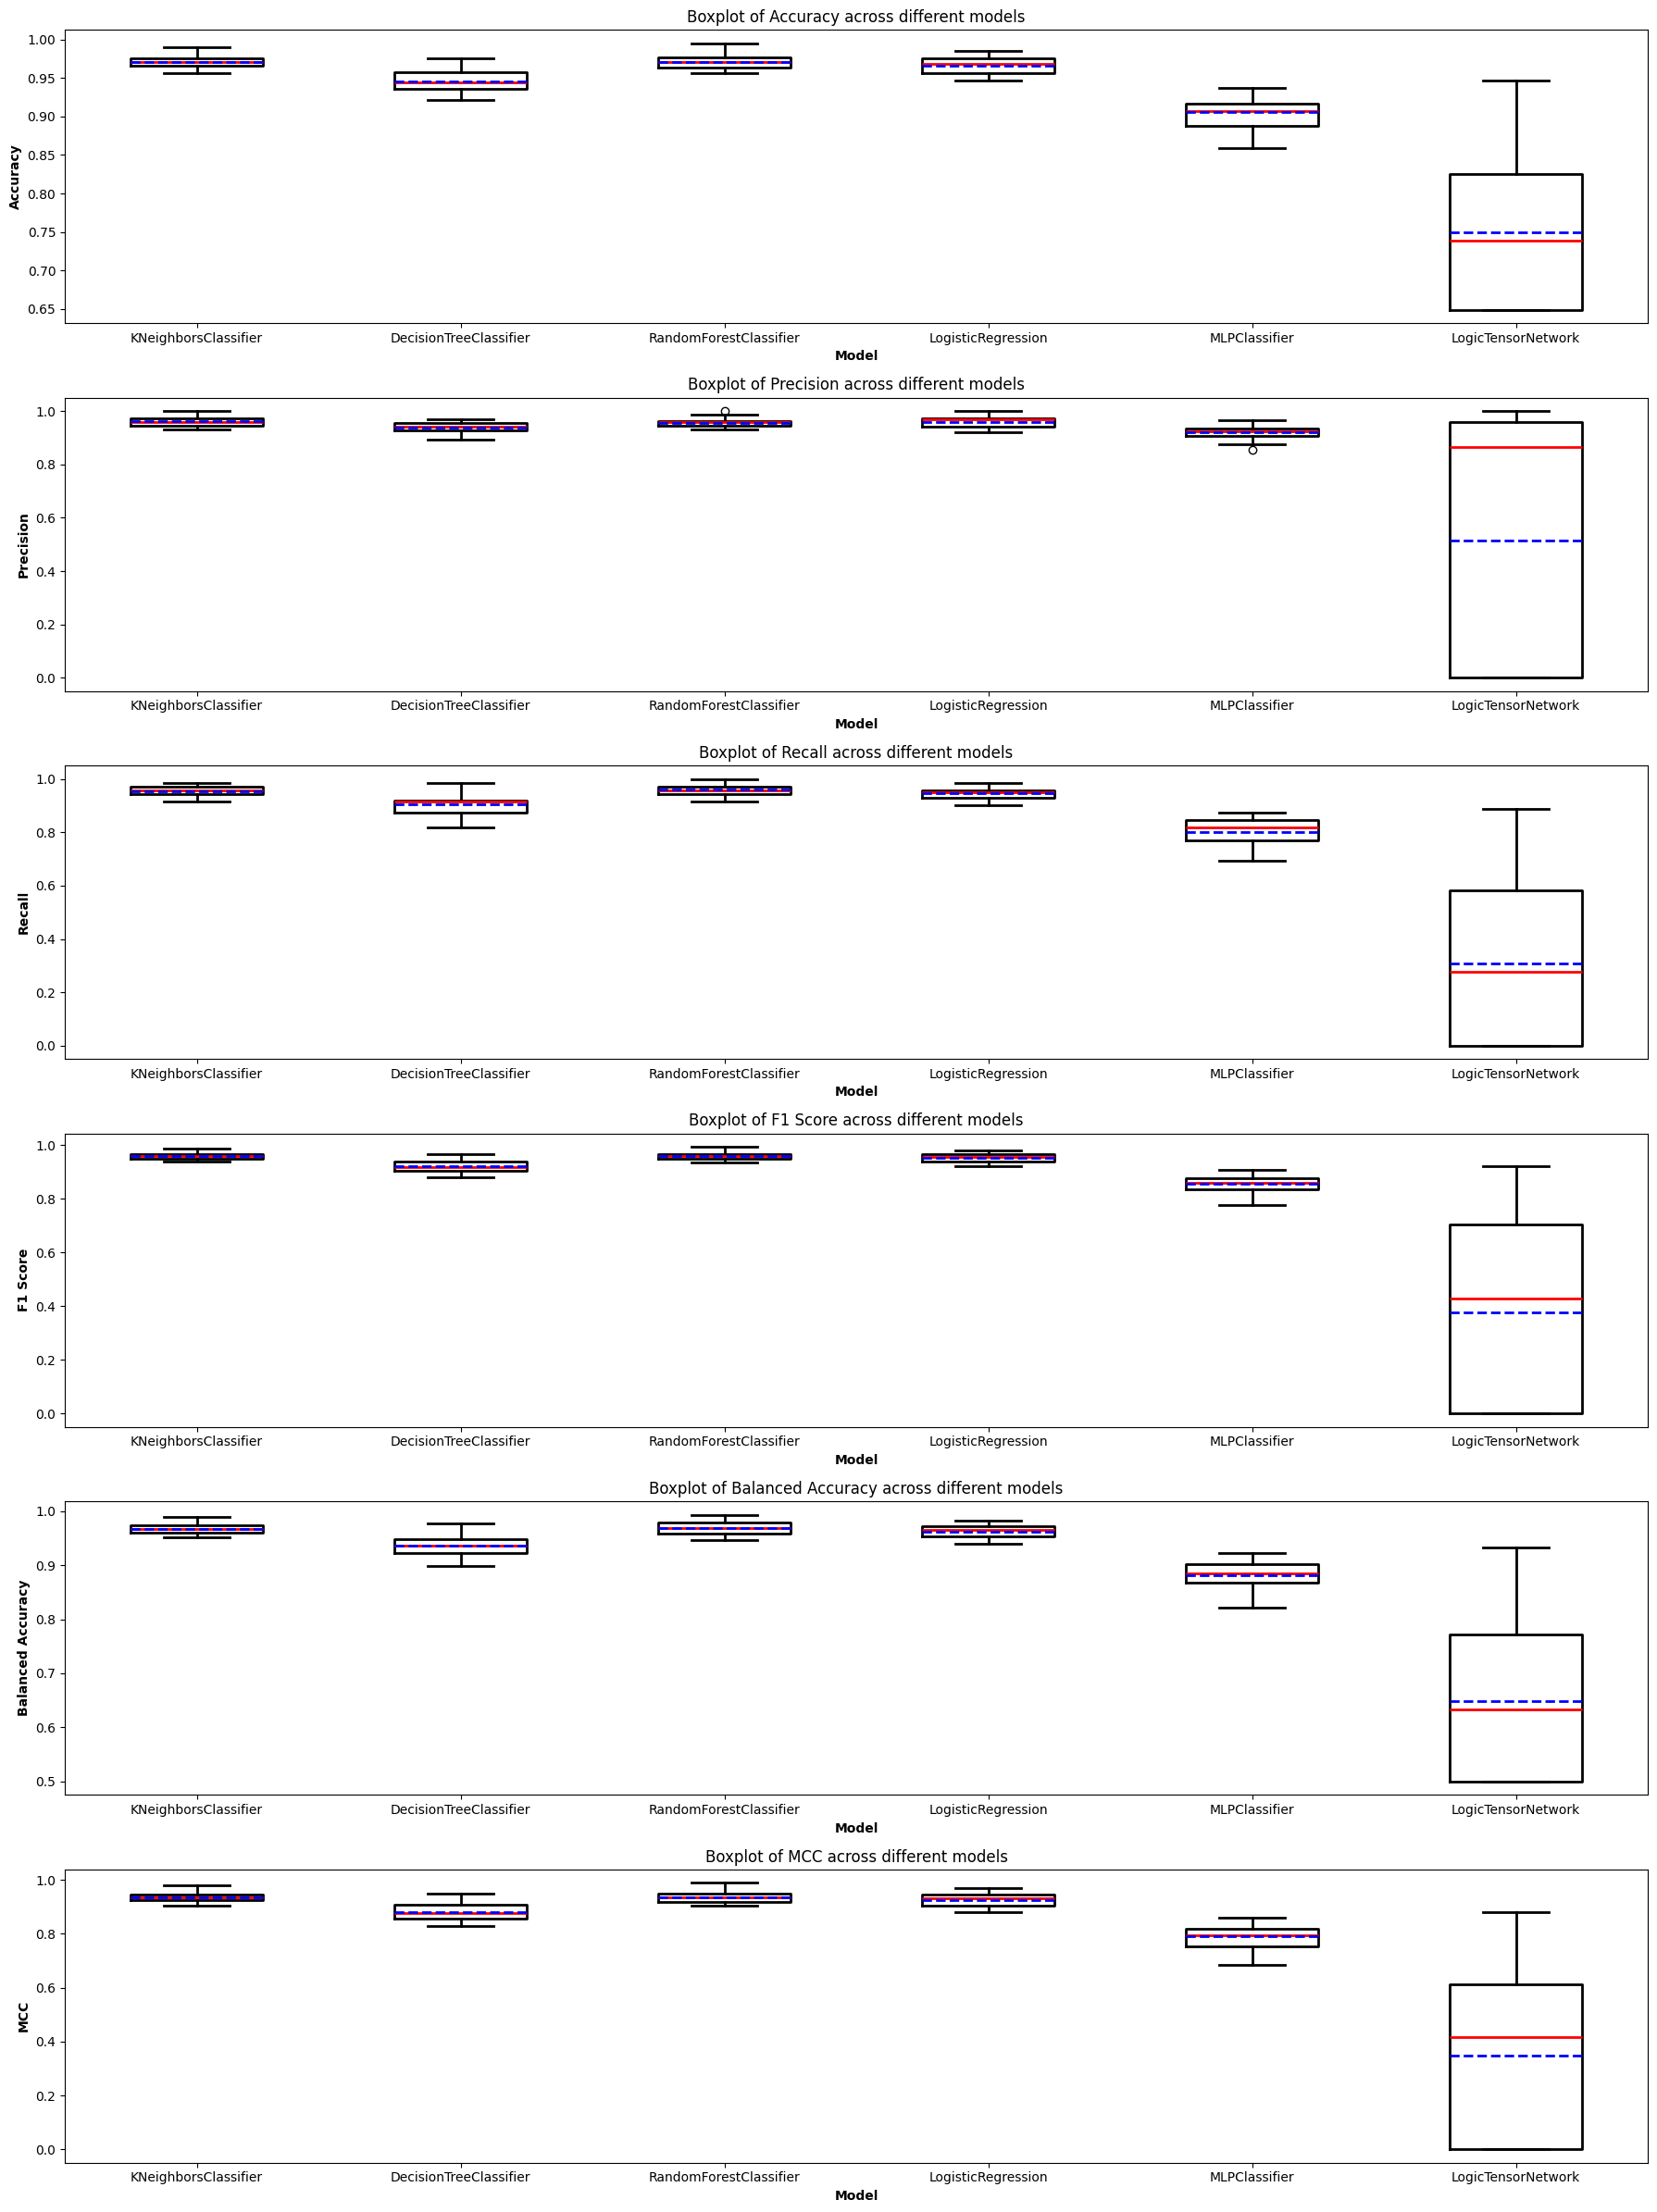

In [29]:
plot_metrics(metrics_df, metrics)

In [30]:
compare_models(metrics_df)


Accuracy:
  KNeighborsClassifier is significantly better than DecisionTreeClassifier (p = 0.0000)
  KNeighborsClassifier is NOT significantly better than RandomForestClassifier (p = 1.0000)
  KNeighborsClassifier is significantly better than LogisticRegression (p = 0.0456)
  KNeighborsClassifier is significantly better than MLPClassifier (p = 0.0000)
  KNeighborsClassifier is significantly better than LogicTensorNetwork (p = 0.0000)

Precision:
  KNeighborsClassifier is significantly better than DecisionTreeClassifier (p = 0.0001)
  KNeighborsClassifier is NOT significantly better than RandomForestClassifier (p = 0.1531)
  KNeighborsClassifier is NOT significantly better than LogisticRegression (p = 0.1258)
  KNeighborsClassifier is significantly better than MLPClassifier (p = 0.0000)
  KNeighborsClassifier is significantly better than LogicTensorNetwork (p = 0.0005)

Recall:
  RandomForestClassifier is NOT significantly better than KNeighborsClassifier (p = 0.3299)
  RandomForestClas

In [31]:
for model in metrics_df.index:
    perform_t_tests(metrics_df, model)
    print()
    print( "-" * 100)


Accuracy:
  KNeighborsClassifier is significantly better than LogicTensorNetwork (p = 0.0000)

Precision:
  KNeighborsClassifier is significantly better than LogicTensorNetwork (p = 0.0005)

Recall:
  KNeighborsClassifier is significantly better than LogicTensorNetwork (p = 0.0000)

F1 Score:
  KNeighborsClassifier is significantly better than LogicTensorNetwork (p = 0.0000)

Balanced Accuracy:
  KNeighborsClassifier is significantly better than LogicTensorNetwork (p = 0.0000)

MCC:
  KNeighborsClassifier is significantly better than LogicTensorNetwork (p = 0.0000)

----------------------------------------------------------------------------------------------------

Accuracy:
  DecisionTreeClassifier is significantly better than LogicTensorNetwork (p = 0.0000)

Precision:
  DecisionTreeClassifier is significantly better than LogicTensorNetwork (p = 0.0007)

Recall:
  DecisionTreeClassifier is significantly better than LogicTensorNetwork (p = 0.0000)

F1 Score:
  DecisionTreeClassifier

# Logic Adherence

## Model Evaluation with 50 Random States

This section evaluates all models across 50 different random states in Logic adherence ( meaning how well aligned are the predictions with the given logic rules ). The following steps are performed:

 ### 1. Box Plot Visualization:  
   Box plots are generated for the evaluation metrics, allowing a clear visual comparison of model performance.
   
   

 ### 2. T-Test Comparisons:  
   Two sets of T-tests are conducted:
   
   - **Best Model Significance Test**:  
     For each rule, the T-test checks if the best-performing model is significantly better than the others.
   
   - **Comparison with Our Model**:  
     For cases where our model is not the best, it is compared against each of the other models for each rule.

### 3. Rules:

  Rule 1: forall person. (((person[BMI] > 29) and (person[Glucose] > 125 )) -> Diabetic(person))"
  
  Rule 2: forall person. (((person[BMI] < 26) and (person[Glucose] < 101 )) -> not Diabetic(person))"



In [32]:
adherence_df.index = model_names

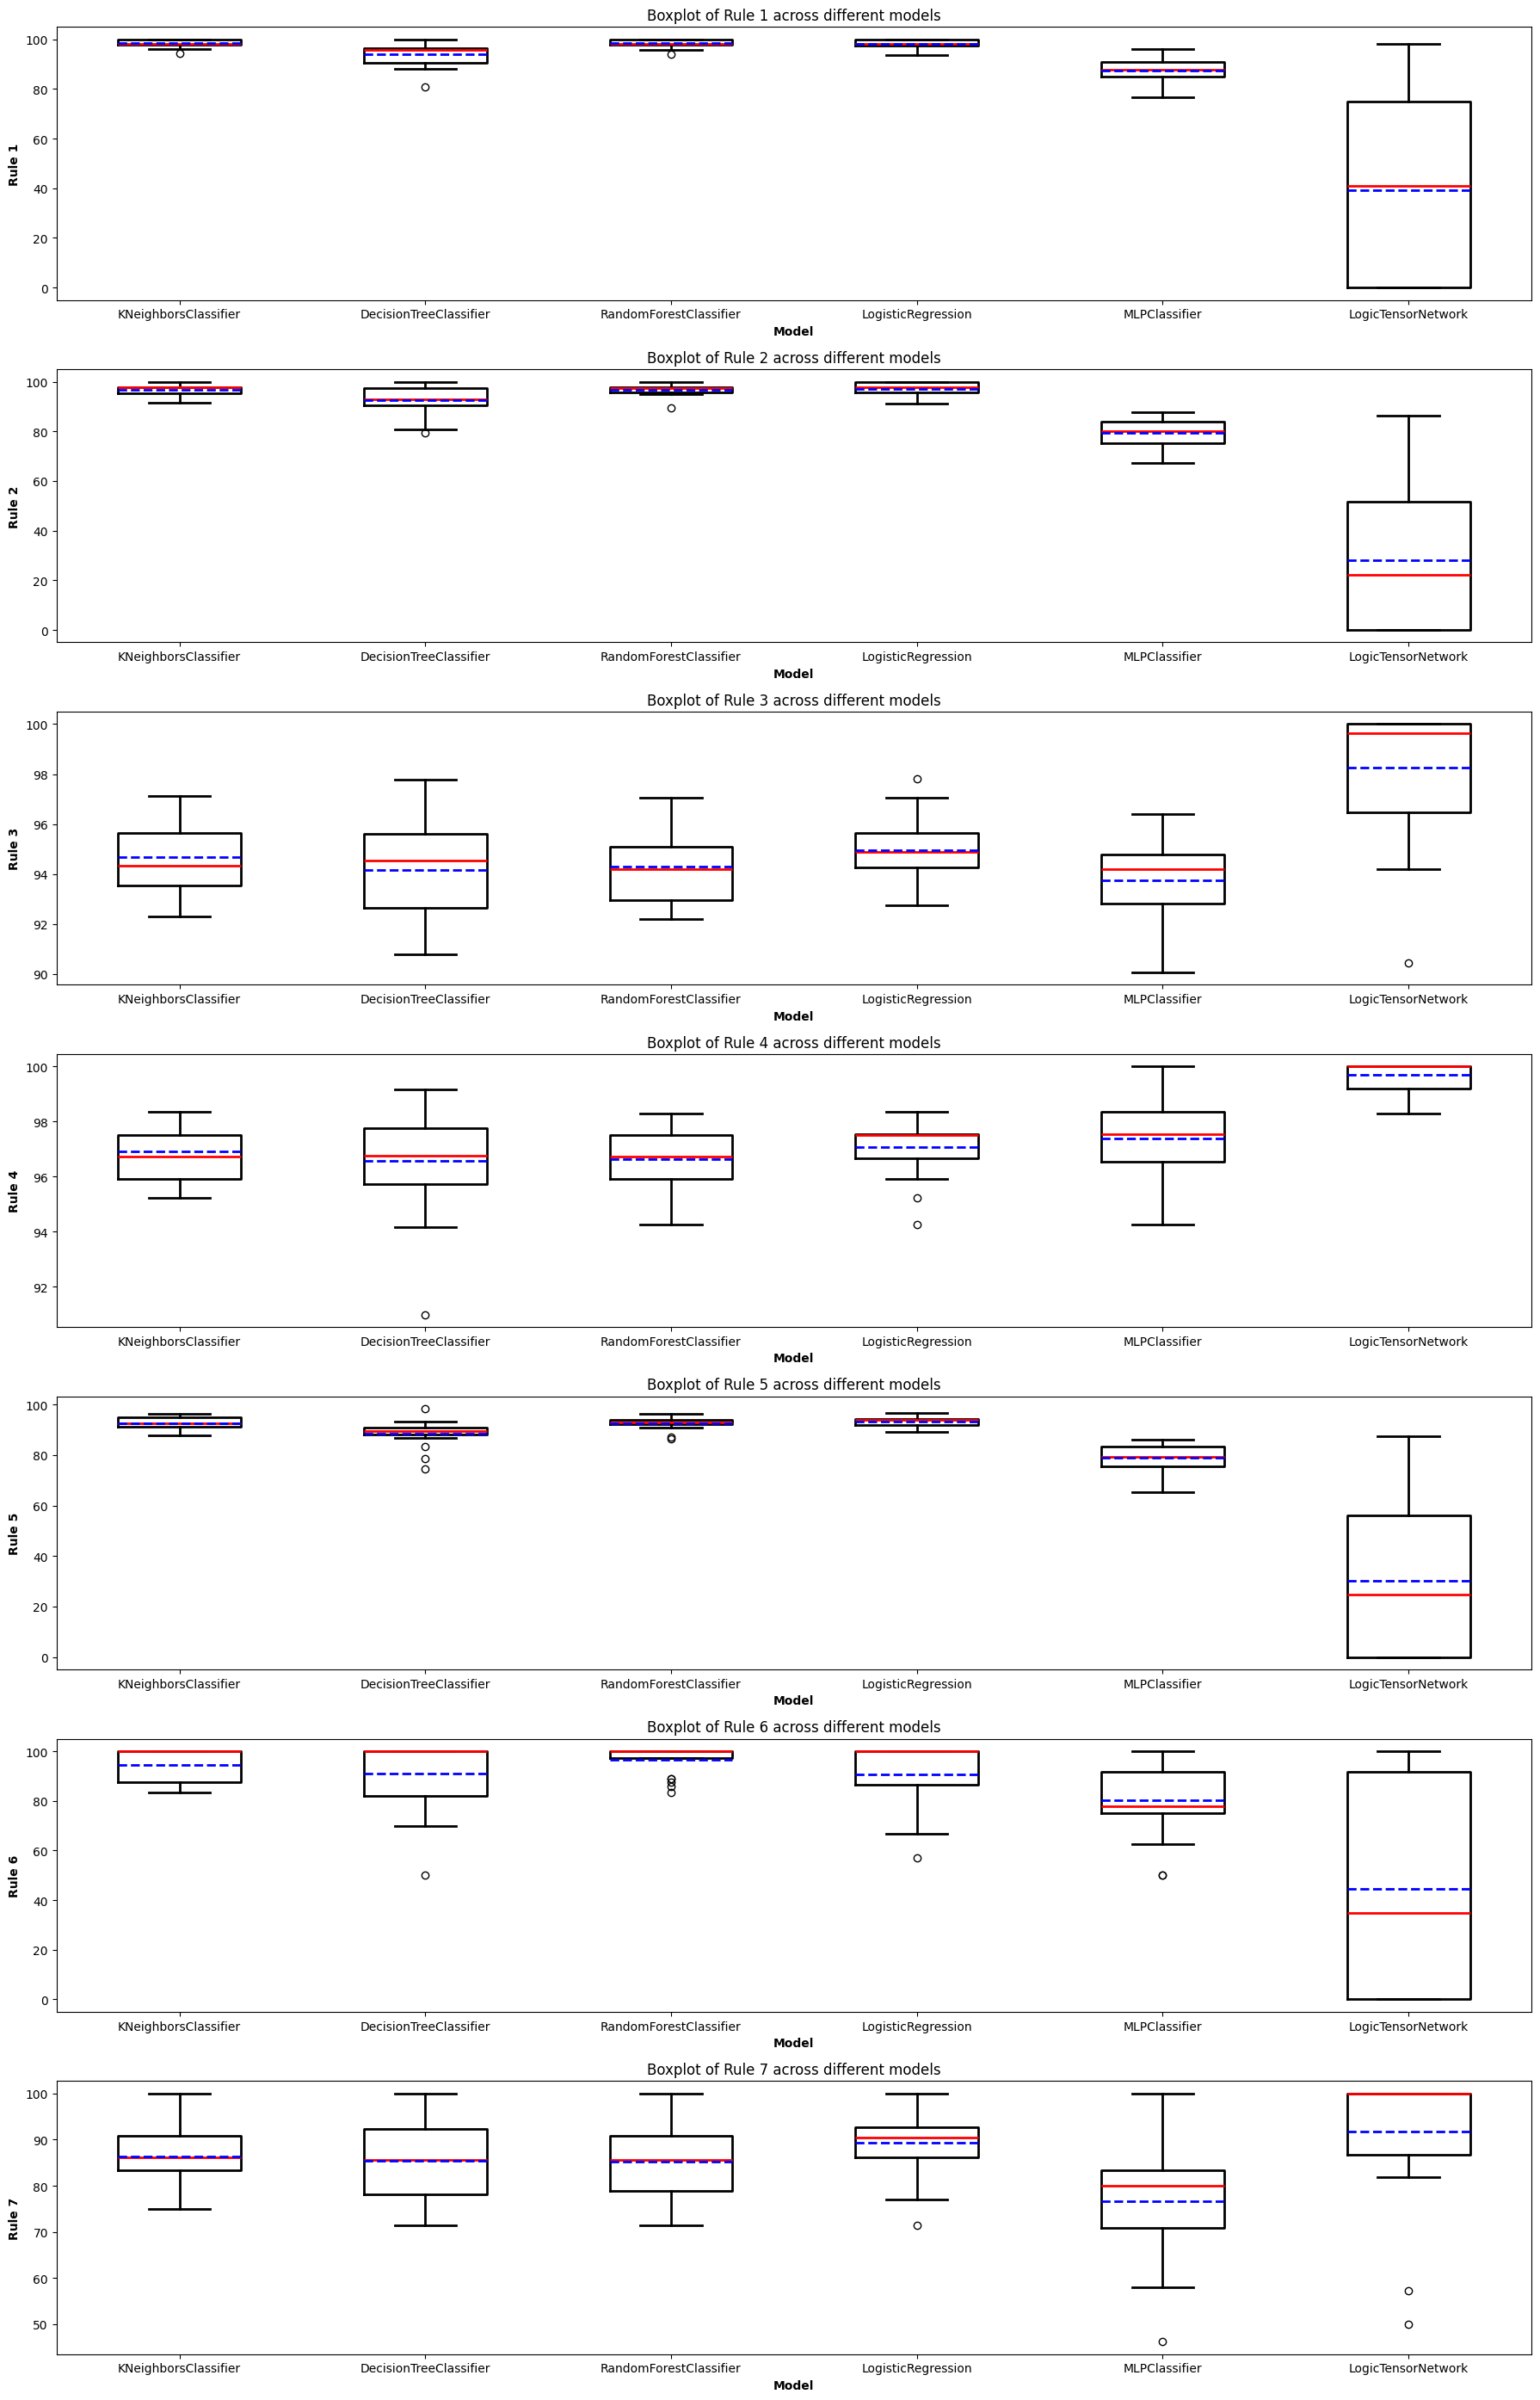

In [33]:
plot_metrics( adherence_df, ["Rule " + str(i) for i in range(1, 8)])

In [34]:
compare_models(adherence_df)


Rule 1:
  KNeighborsClassifier is significantly better than DecisionTreeClassifier (p = 0.0003)
  KNeighborsClassifier is NOT significantly better than RandomForestClassifier (p = 0.7734)
  KNeighborsClassifier is NOT significantly better than LogisticRegression (p = 0.4050)
  KNeighborsClassifier is significantly better than MLPClassifier (p = 0.0000)
  KNeighborsClassifier is significantly better than LogicTensorNetwork (p = 0.0000)

Rule 2:
  LogisticRegression is NOT significantly better than KNeighborsClassifier (p = 0.8288)
  LogisticRegression is significantly better than DecisionTreeClassifier (p = 0.0011)
  LogisticRegression is NOT significantly better than RandomForestClassifier (p = 0.5836)
  LogisticRegression is significantly better than MLPClassifier (p = 0.0000)
  LogisticRegression is significantly better than LogicTensorNetwork (p = 0.0000)

Rule 3:
  LogicTensorNetwork is significantly better than KNeighborsClassifier (p = 0.0001)
  LogicTensorNetwork is significant

In [35]:
for model in metrics_df.index:
    perform_t_tests(adherence_df, model)
    print()
    print( "-" * 100)


Rule 1:
  KNeighborsClassifier is significantly better than LogicTensorNetwork (p = 0.0000)

Rule 2:
  KNeighborsClassifier is significantly better than LogicTensorNetwork (p = 0.0000)

Rule 3:
  LogicTensorNetwork is significantly better than KNeighborsClassifier (p = 0.0001)

Rule 4:
  LogicTensorNetwork is significantly better than KNeighborsClassifier (p = 0.0000)

Rule 5:
  KNeighborsClassifier is significantly better than LogicTensorNetwork (p = 0.0000)

Rule 6:
  KNeighborsClassifier is significantly better than LogicTensorNetwork (p = 0.0001)

Rule 7:
  There is no significant difference between LogicTensorNetwork and KNeighborsClassifier (p = 0.0919)

----------------------------------------------------------------------------------------------------

Rule 1:
  DecisionTreeClassifier is significantly better than LogicTensorNetwork (p = 0.0000)

Rule 2:
  DecisionTreeClassifier is significantly better than LogicTensorNetwork (p = 0.0000)

Rule 3:
  LogicTensorNetwork is signif